# Exploring NYC Taxi Ride Data 
By Aleksa Basara





# Part 1: Introduction


## A) Project Description


### About the Topic



I came across an article this year about a topic I had never considered before -- the price of NYC taxi medallions. The NYC Taxi and Limousine Commission only has about 13,000 in circulation and they typically go for no less than 100,000 dollars but have reached as high as $1.3 million in 2013. When I saw these prices, I immediately thought NYC taxi drivers were moguls in disguise. After some digging, I learned that many lease or split their profits with the companies that own the taxi drivers. After paying off the company, they walk away with little more than minimum wage and often work more than 12 hour shifts to make ends meet. 

As they don't set their own rates, it seemed the best ways to make more money would be to either work more hours or earn more from tips. I decided to explore taxi trip data to see if I could learn more about taxi rides and how much people tip. I ended up finding just the data I was looking for... but for Green Taxis.

Green taxis are similar to yellow taxis, with a few key differences. They are also metered rides; however, they don't do on-street hail rides on yellow taxi turf (Manhatten below 110th street on the West side and 96th on the east). Nonetheless, the data I found gave valuable information about location, duration, and payment amount for each trip.

### Where does the data come from?

The 2016 NYC Green Taxi dataset contains 16.4 million rows and 23 columns. It represents trip records from all rides taken in green taxis in NYC in 2016. The data was taken from NYC OpenData and can be found here: https://data.cityofnewyork.us/Transportation/2016-Green-Taxi-Trip-Data/hvrh-b6nb

I highly recommend also downloading and studying the data dictionary for the trip record data found on the same page with the data download. Reading this dictionary will help you understand the variables in the dataset so you know what to look out for in the cleaning process.

The trip record dataset mentioned above contains both latitude/longitude of the pickup/dropoff locations. It also contains data on 265 Location IDs throughout the city, numbered 1-265. As IDs representing area segments are simpler to conceptualize than coordinates, I merged the trip record dataset with a dataset containing the ID number, borough, zone, and service zone. This data can be found through the NYC Taxi & Limousine Commision, here: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml  

## B) Import Packages and Finalize Dataset


In [10]:
#Import necessary packages
#install.packages("data.table")
library(data.table) #Package for large data processing

install.packages('devtools')#Package for installing from github
library(devtools)
install_github("ujjwalkarn/xda") #Install XDA
library(xda) #Package for exploratory data analysis made by Ujjwal Karn 

#install.packages("lubridate")
library(lubridate) #Handling dates

#install.packages("dyplr")
library(dplyr) #R grammar

#install.packages("ggplot2")
library(ggplot2) #Data viz

install.packages("gplots")
library(gplots) #Data viz

#install.packages("reshape2")
library(reshape2) #Mostly for melt function

Warning message:
"package 'devtools' is in use and will not be installed"Skipping install of 'xda' from a github remote, the SHA1 (86cf14db) has not changed since last install.
  Use `force = TRUE` to force installation
Warning message:
"package 'gplots' is in use and will not be installed"

### Data Import Options

**Option 1 (Default)-- **
This is for those who have only downloaded the raw datasets and have NOT yet done any merging or cleaning. Most people will likely choose this option. Once you complete Option 1, SKIP Option 2 and then proceed to Part 2: Data Cleaning

**Option 2 -- **
This is for those running the code who have already once been through Option 1 AND have completed "Part 2: Data Cleaning" AND have already exported the resulting dataset to their computer. There is only ONE dataset being downloaded in this step, and should be smaller than the "main" dataset being downloaded in Option 1. If you go through Option 2, SKIP "Part 2: Data Cleaning".

### Data Import Option 1 -- First time run-through import and merge


In [11]:
#Import main dataset with trip record data
setwd("C:/Documents/Data Science Projects/1 - NYC Taxi Drivers/Data")
mainData = fread("2016_taxi_data.csv")

Read 16385532 rows and 23 (of 23) columns from 2.076 GB file in 00:02:07


In [12]:
#Import Pickup (PU) Location ID dataset and merge with main dataset
PUzoneData = fread("PUtaxiZones.csv")
merge1Data = merge(mainData, PUzoneData)

In [13]:
#Import Dropoff (DO) Location ID dataset and merge with merge1Data
DOzoneData = fread("DOtaxiZones.csv")
merge2Data = merge(merge1Data, DOzoneData, by="DOLocationID")

As Option 2 users may want to reuse some of the commands in "Part 2: Data Cleaning Step", we will name our data the same thing as we would in Option 2. So for both Parts 2 and 3, our starting dataset will be named: taxiDT. 

In [14]:
taxiDT = merge2Data

### Data Import Option 2 -- For those already with a merged, cleaned, and smaller dataset

In [15]:
#setwd("C:/Documents/Data Science Projects/1 - NYC Taxi Drivers/Data")
#taxiDT = fread("small_taxi_data.csv") #We really just change and use the first fread() statement from Option 1

# Part 2: Data Cleaning


## A) Take a preliminary look at the data

In [16]:
#Get column names of the dataset
colnames(taxiDT)

[1] "DOLocationID"          "PULocationID"          "VendorID"             
 [4] "lpep_pickup_datetime"  "Lpep_dropoff_datetime" "Store_and_fwd_flag"   
 [7] "RateCodeID"            "Pickup_longitude"      "Pickup_latitude"      
[10] "Dropoff_longitude"     "Dropoff_latitude"      "Passenger_count"      
[13] "Trip_distance"         "Fare_amount"           "Extra"                
[16] "MTA_tax"               "Tip_amount"            "Tolls_amount"         
[19] "Ehail_fee"             "improvement_surcharge" "Total_amount"         
[22] "Payment_type"          "Trip_type"             "PUborough"            
[25] "PUzone"                "PU_service_zone"       "DOborough"            
[28] "DOzone"                "DO_service_zone"

In [17]:
dim(taxiDT)

[1] 7367502      29


Wait -- there are only 7.36 million rows, around 9 million fewer than the 16+ million rows we started out with! I hypothesize this is due to our merge from the data import step. In this step, we used an inner join, which combines the datasets so the resulting dataset contains only entries with values found in both datasets. This means if there were missing LocationIDs, they would have been dropped from the dataset. 

In the below output, we see the number of missing LocationIDs is about 9 million. Coincidentally, we see that the number of rows left (7.36 million) is the same number of rows missing for the pickup/dropoff coordinate data. Checking this overlap, we see that no rows missing LocationID are also missing coordinate data and vice versa!

In [18]:
#Take a look at number of missing values from all variables of the original main dataset with record data
colSums(is.na(mainData))

VendorID  lpep_pickup_datetime Lpep_dropoff_datetime 
                    0                     0                     0 
   Store_and_fwd_flag            RateCodeID      Pickup_longitude 
                    0                     0               7367502 
      Pickup_latitude     Dropoff_longitude      Dropoff_latitude 
              7367502               7367502               7367502 
      Passenger_count         Trip_distance           Fare_amount 
                    0                     0                     0 
                Extra               MTA_tax            Tip_amount 
                    0                     0                     0 
         Tolls_amount             Ehail_fee improvement_surcharge 
                    0              16385532                     0 
         Total_amount          Payment_type             Trip_type 
                    0                     0                   472 
         PULocationID          DOLocationID 
              9018030               9018030

In [19]:
#Check overlap between coordinate and LocationID data
table(is.na(mainData$Pickup_longitude), is.na(mainData$PULocationID))

       
          FALSE    TRUE
  FALSE       0 9018030
  TRUE  7367502       0


We will now get a summary of the data to get a basic idea of what the data looks like. We use this step to make sure our data makes sense (no unwanted missing values or values that doesn't make sense -- e.g. a negative value for a variable that should only take positive values).

In [20]:
#Get summary of data
summary(taxiDT)

  DOLocationID    PULocationID      VendorID     lpep_pickup_datetime
 Min.   :  1.0   Min.   :  1.0   Min.   :1.000   Length:7367502      
 1st Qu.: 61.0   1st Qu.: 49.0   1st Qu.:2.000   Class :character    
 Median :129.0   Median : 89.0   Median :2.000   Mode  :character    
 Mean   :129.4   Mean   :114.6   Mean   :1.794                       
 3rd Qu.:193.0   3rd Qu.:179.0   3rd Qu.:2.000                       
 Max.   :265.0   Max.   :265.0   Max.   :2.000                       
                                                                     
 Lpep_dropoff_datetime Store_and_fwd_flag   RateCodeID    Pickup_longitude 
 Length:7367502        Length:7367502     Min.   : 1.00   Min.   : NA      
 Class :character      Class :character   1st Qu.: 1.00   1st Qu.: NA      
 Mode  :character      Mode  :character   Median : 1.00   Median : NA      
                                          Mean   : 1.09   Mean   :NaN      
                                          3rd Qu.: 1.00   3r

From the above summary output, we notice several things.

1) There are variables that should be treated as categorical variables but are instead being treated as numerical, continous variables. To correct this, we should redefine them.

2) This output doesn't conveniently also show the number of missing values for each variable. After some research, I found a solid package that gives the breakdown of categorical variables and continous variables separately, as well as reports the number of missing values for both. However, we will only look at the categorical variables that don't have so many levels that it'd be impractical to analyze them. We also won't look at whether the data collected was first stored then forwarded.

In [21]:
#Redefine categorical variables
taxiDT$PULocationID = as.factor(taxiDT$PULocationID)
taxiDT$DOLocationID = as.factor(taxiDT$DOLocationID)
taxiDT$Payment_type = as.factor(taxiDT$Payment_type)
taxiDT$VendorID = as.factor(taxiDT$VendorID)
taxiDT$RateCodeID = as.factor(taxiDT$RateCodeID)
taxiDT$Trip_type = as.factor(taxiDT$Trip_type)

In [22]:
#Use xda package to get summary of categorical variables
badCatVar = c('lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Store_and_fwd_flag', 
              'trip_date') #Exclude variables whose distributions we don't care about
charSummary(taxiDT[,!(names(taxiDT) %in% badCatVar), with=FALSE])

,n,miss,miss%,unique,top5levels:count
DOLocationID,7367502,0,0.0000000000,263,"42:236016, 74:232634, 7:221853, 41:210571, 129:201447"
PULocationID,7367502,0,0.0000000000,258,"74:414336, 41:401061, 7:357081, 75:344590, 255:317145"
VendorID,7367502,0,0.0000000000,2,"2:5847074, 1:1520428"
RateCodeID,7367502,0,0.0000000000,7,"1:7184406, 5:153283, 2:19095, 3:5770, 4:4797"
Payment_type,7367502,0,0.0000000000,5,"2:3712938, 1:3601317, 3:33294, 4:19637, 5:316"
Trip_type,7367474,28,0.0003800474,3,"1:7214073, 2:153401"
PUborough,7367502,0,0.0000000000,7,"Brooklyn:2711023, Manhattan:2228193, Queens:2098011, Bronx:314927, Unknown:13723"
PUzone,7364276,3226,0.0437868900,257,"East Harlem North:414336, Central Harlem:401061, Astoria:357081, East Harlem South:344590, Williamsburg (North Side):317145"
PU_service_zone,7367502,0,0.0000000000,5,"Boro Zone:7251071, Yellow Zone:99703, N/A:13723, Airports:2825, EWR:180"
DOborough,7367502,0,0.0000000000,7,"Manhattan:2612339, Brooklyn:2231717, Queens:2058978, Bronx:430804, Unknown:27496"


RateCodeID should have only 6 levels, but instead it has 7. We see below some entries are coded as 99, which likely mean they were invalid or missing. We shall remove these entries shortly.

In [23]:
unique(taxiDT$RateCodeID)

[1] 5  1  3  2  4  6  99
Levels: 1 2 3 4 5 6 99

We next look at the continous variables. Since we know the coordinate information will be missing, we will omit them from our summary.

In [24]:
#Use xda package to get summary of continous variables
badContVar = c('Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 
              'Dropoff_latitude') #Exclude variables whose distributions we don't care about
numSummary(taxiDT[,!(names(taxiDT) %in% badContVar), with=FALSE])

,n,mean,sd,max,min,range,nunique,nzeros,iqr,lowerbound,...,mode,miss,miss%,1%,5%,25%,50%,75%,95%,99%
Passenger_count,7367502,1.358,1.0256,9.0,0.0,9.0,10,1178,0.00,1.00,...,1.0,0,0,1.0,1.00,1.00,1.00,1.00,5.00,6.00
Trip_distance,7367502,2.785,2.9389,698.6,0.0,698.6,4317,99175,2.44,-2.64,...,0.0,0,0,0.0,0.46,1.02,1.81,3.46,8.29,14.38
Fare_amount,7367502,12.121,10.4377,5005.5,-499.0,5504.5,2059,19807,8.00,-5.50,...,6.0,0,0,2.5,4.00,6.50,9.00,14.50,29.50,50.00
Extra,7367502,0.353,0.3818,4.5,-4.5,9.0,16,3422118,0.50,-0.75,...,0.0,0,0,0.0,0.00,0.00,0.50,0.50,1.00,1.00
MTA_tax,7367502,0.487,0.0856,0.5,-0.5,1.0,4,165452,0.00,0.50,...,0.5,0,0,0.0,0.50,0.50,0.50,0.50,0.50,0.50
Tip_amount,7367502,1.211,2.4360,714.0,-51.4,765.4,3068,4308749,2.00,-3.00,...,0.0,0,0,0.0,0.00,0.00,0.00,2.00,5.00,8.95
Tolls_amount,7367502,0.110,1.0898,900.0,-50.0,950.0,412,7229937,0.00,0.00,...,0.0,0,0,0.0,0.00,0.00,0.00,0.00,0.00,5.54
improvement_surcharge,7367502,0.292,0.0511,0.3,-0.3,0.6,3,162235,0.00,0.30,...,0.3,0,0,0.0,0.30,0.30,0.30,0.30,0.30,0.30
Total_amount,7367502,14.612,11.8643,5006.3,-499.0,5505.3,10245,18865,9.50,-6.45,...,6.8,0,0,3.8,5.30,7.80,11.30,17.30,35.00,56.84


## B) Invalid entries


 These variables appear to have invalid entries:
 
  -  **Payment_type: ** Since we are ultimately interested in the tip percent, we have to consider that tip was only recorded for trips paid for with credit card -- according to the data dictionary. Hence, we will only be interested in the rows with Payment_type = 1.
  
  
  - **Fare_amount: ** Some values are negative. Since tip % will be be Tip_amount divided by (predominantly) Fare_amount, we will also restrict this Fare_amount variable to be strictly greater than 0 in order not to avoid an infinite tip %.
  
  
  - **Extra, MTA_tax, Tip_amount, Tolls_amount, Improvement_surcharge: ** These variables have negative values when they shouldn't. We will assume error and remove these entries.

## C) Missing values


These variables appear to have missing values:

- **Categorical Variables: ** Of these categorical variables, I see that no variable is missing than 0.25%. This means that it is likely safe to eliminate the rows with these missing values for: Trip_type, PUzone, and DOzone. This will not bias any future results too much.


## D) Add useful variables + Subset data

In [25]:
#Add month variable
taxiDT$lpep_pickup_datetime = as.character(taxiDT$lpep_pickup_datetime)
taxiDT$trip_date = substr(taxiDT$lpep_pickup_datetime, 0, 10) #Extracts the date (without the timestamp)
taxiDT$month = substr(taxiDT$lpep_pickup_datetime, 0, 2)

#Add weekday variable
taxiDT$weekday = weekdays(as.Date(taxiDT$trip_date, format = "%m/%d/%Y"))

#Add military_time, pickup_hour, dropoff_hour, time_elapsed
taxiDT$PUhour = paste(substr(taxiDT$lpep_pickup_datetime, 12, 13), 
                      substr(taxiDT$lpep_pickup_datetime, 21, 22))

In [26]:
#Subset data to adjust for missing/invalid values
taxiDT2 = taxiDT[taxiDT$Payment_type == 1 & taxiDT$Fare_amount > 0 & taxiDT$Extra >= 0 & taxiDT$MTA_tax >= 0 &
                   taxiDT$improvement_surcharge >= 0 & taxiDT$Tip_amount >= 0 & !is.na(Trip_type) &
                   !is.na(taxiDT$PUzone) & !is.na(taxiDT$DOzone)]

In [27]:
#Add tip_percent variable
taxiDT2$nonTip = taxiDT2$Total_amount - taxiDT2$Tip_amount
taxiDT2$tip_percent = round((taxiDT2$Tip_amount/taxiDT2$nonTip),4)

#Remove unnecessary variables
taxiDT3 = taxiDT2[, c("Pickup_longitude", "Pickup_latitude", 
                      "Dropoff_longitude", "Dropoff_latitude", "Ehail_fee"):=NULL]


In [28]:
#Standardize data table name back to taxiDT
taxiDT = taxiDT3

#write to csv
#fwrite(taxiDT, "small_taxi_data.csv")

# Part 3: Exploratory Data Analysis


## A) General


In [29]:
#Make categorical variables factor 
taxiDT$Payment_type = as.factor(taxiDT$Payment_type)
taxiDT$VendorID = as.factor(taxiDT$VendorID)
taxiDT$RateCodeID = as.factor(taxiDT$RateCodeID)
taxiDT$Trip_type = as.factor(taxiDT$Trip_type)
taxiDT$month = as.factor(taxiDT$month)

In [30]:
#Get first few rows of data
head(taxiDT)

DOLocationID,PULocationID,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Passenger_count,Trip_distance,Fare_amount,...,PU_service_zone,DOborough,DOzone,DO_service_zone,trip_date,month,weekday,PUhour,nonTip,tip_percent
1,1,2,07/01/2016 10:00:58 AM,07/01/2016 10:01:00 AM,N,5,2,0,75.0,...,EWR,EWR,Newark Airport,EWR,07/01/2016,07,Friday,10 AM,75.0,0.2000
1,1,2,07/01/2016 01:24:00 PM,07/01/2016 01:24:05 PM,N,5,1,0,92.0,...,EWR,EWR,Newark Airport,EWR,07/01/2016,07,Friday,01 PM,92.0,0.2000
1,1,2,07/03/2016 06:50:13 PM,07/03/2016 06:50:33 PM,N,5,1,0,116.7,...,EWR,EWR,Newark Airport,EWR,07/03/2016,07,Sunday,06 PM,116.7,0.0857
1,1,2,07/06/2016 12:14:30 PM,07/06/2016 12:15:06 PM,N,5,2,0,82.0,...,EWR,EWR,Newark Airport,EWR,07/06/2016,07,Wednesday,12 PM,82.0,0.0000
1,1,2,07/10/2016 12:56:23 PM,07/10/2016 12:56:26 PM,N,5,1,0,4.3,...,EWR,EWR,Newark Airport,EWR,07/10/2016,07,Sunday,12 PM,4.3,0.2000
1,1,2,07/12/2016 09:09:04 AM,07/12/2016 09:10:27 AM,N,5,1,0,120.0,...,EWR,EWR,Newark Airport,EWR,07/12/2016,07,Tuesday,09 AM,120.0,0.0000


### Figure 1: Average Daily Ridership 

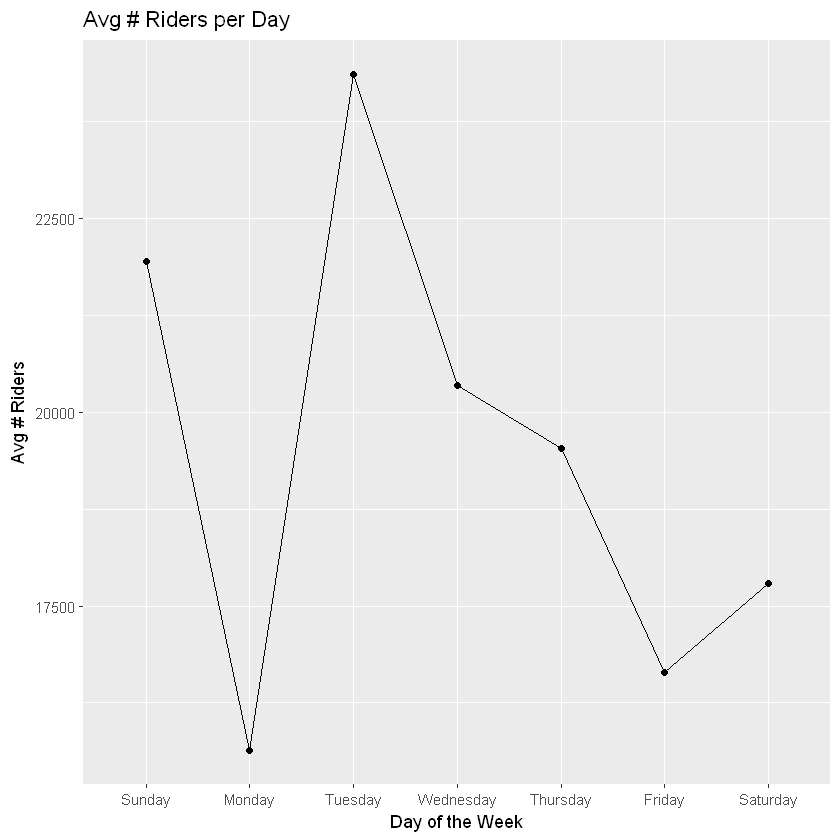

In [31]:
#CHART 1 -- AVERAGE DAILY RIDERSHIP line chart
#Define needed variables
ridersByDay = taxiDT %>% group_by(weekday) %>% count()

dayCount = taxiDT[, length(unique(trip_date)), by = 'weekday']

dayRiders = merge(dayCount, ridersByDay, by = 'weekday')

#Re-order by calendar order
dayRiders$weekday = ordered(dayRiders$weekday, levels =  c("Sunday", "Monday", "Tuesday",
                                "Wednesday", "Thursday", "Friday",
                                "Saturday"))

#Make the line plot
ggplot(data = dayRiders[order(dayRiders$weekday)], aes(weekday, 
                                                       (dayRiders$n/dayRiders$V1),group=1)) + 
      geom_point() +
      geom_line() + 
      labs(x="Day of the Week", y="Avg # Riders", title = "Avg # Riders per Day")

It looks like these taxis get the most traffic on Tuesdays and Sundays!

### Figure 2: Passenger Count -- How many people get in a Taxi?

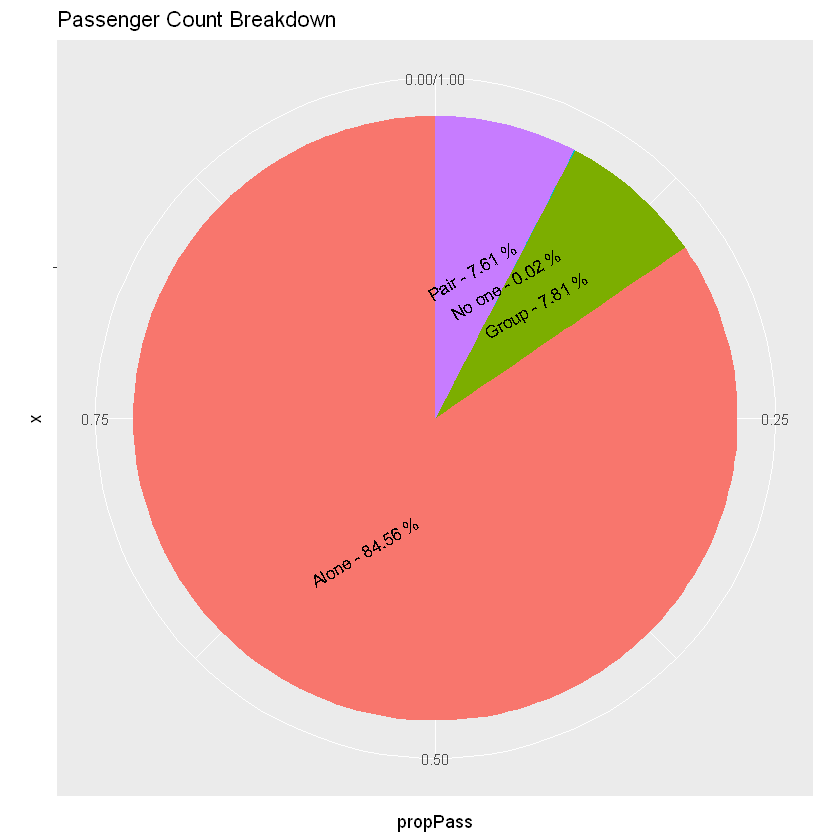

In [34]:
#CHART 2 -- PASSENGER COUNT pie chart
#Categorize passenger counts into group types
taxiDT$passCount = ifelse(taxiDT$Passenger_count ==0, "No one", 
                          ifelse(taxiDT$Passenger_count == 1, "Alone",
                          ifelse(taxiDT$Passenger_count == 2, "Pair", 
                          ifelse(taxiDT$Passenger_count > 2, "Group", taxiDT$Passenger_count))))

# Make smaller dataframe with just proportions of passenger group types
numPas = taxiDT %>% group_by(passCount) %>% count() 
passGroupType = transform(numPas, propPass = n/sum(n))

passGroupType$label = paste(passGroupType$passCount, 
                            paste(round(passGroupType$propPass*100, 2), "%"), sep = " - ")

# Draw pie chart of passenger group types
ggplot(data=passGroupType, mapping = aes(x="", y= propPass, fill = passCount)) + 
        geom_bar(width=1, stat="identity", show.legend = FALSE) +
        coord_polar(theta = "y") +
        labs(title = "Passenger Count Breakdown") +
        geom_text(aes(label = label),
                  position = position_stack(vjust=0.5),size=3.5, angle=30) 

### Figure 3: Trip Distance 

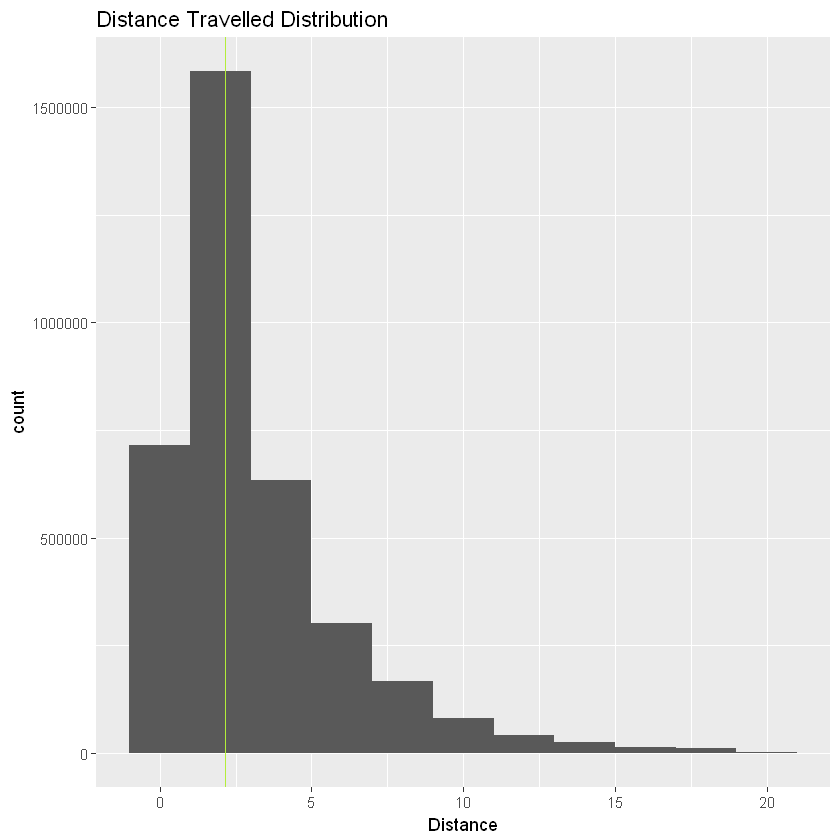

In [35]:
#CHART 3 -- TRIP DISTANCE histogram
qplot(taxiDT[Trip_distance < 20]$Trip_distance, geom="histogram", binwidth = 2) +  
      xlab("Distance") + 
      ggtitle("Distance Travelled Distribution") +
      geom_vline(aes(xintercept = median(taxiDT$Trip_distance)), color = "olivedrab2") 
      #geom_vline(aes(xintercept = mean(taxiDT$Trip_distance)), color = "red")

Most rides last for less than 5 miles, with 50% of all rides lasting less than 2 miles.

### Figure 4: Non-Tip Amount Paid

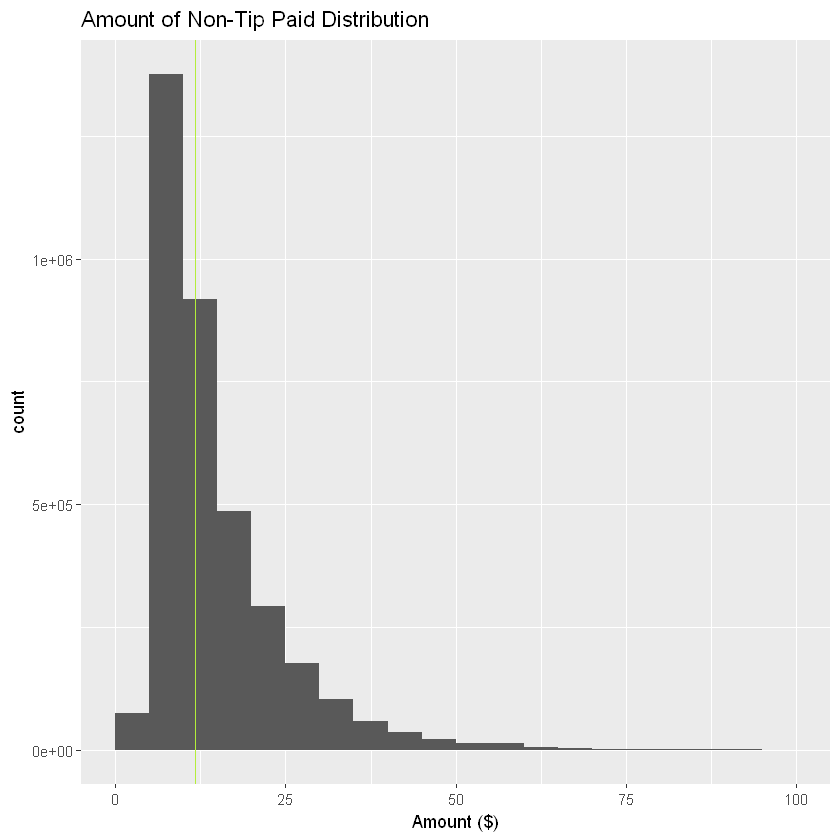

In [36]:
#CHART 4 -- NON-TIP AMOUNT histogram
qplot(taxiDT[nonTip < 100]$nonTip, geom="histogram",breaks = seq(0, 100, 5)) +  
  xlab("Amount ($)") + 
  ggtitle("Amount of Non-Tip Paid Distribution") +
  geom_vline(aes(xintercept = median(taxiDT$nonTip)), color = "olivedrab2")  
  #geom_vline(aes(xintercept = mean(taxiDT$nonTip)), color = "red")

Including fees for tolls and surcharges, it appears that 50% of riders pay less than $12 per trip (before paying tip).

### Figure 5: Tip Percent

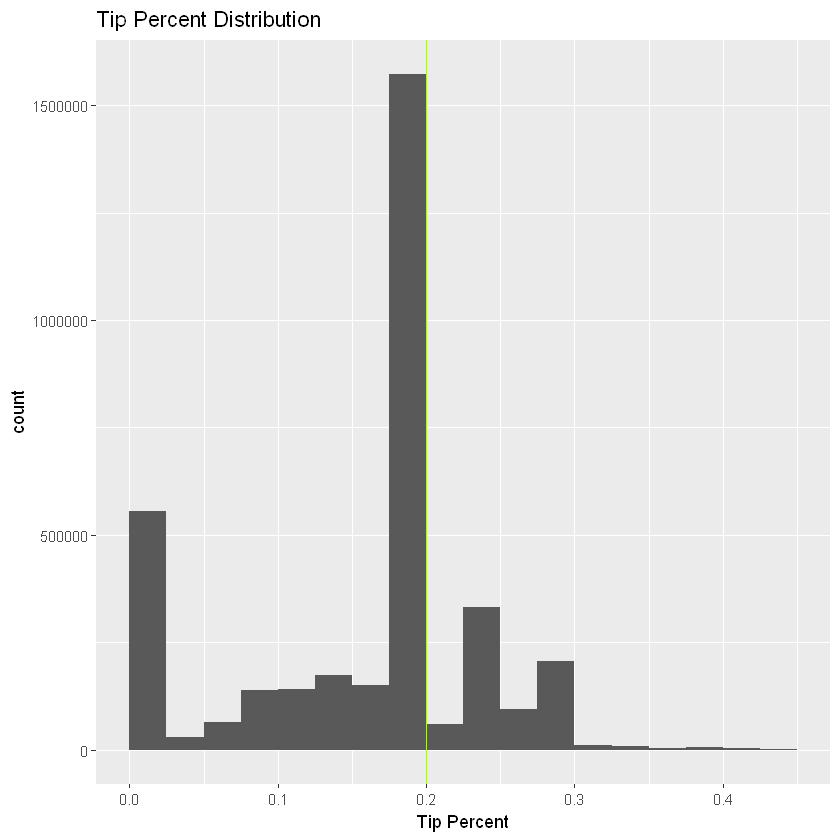

In [37]:
#CHART 5 -- TIP PERCENT histogram
qplot(taxiDT[tip_percent < 0.45]$tip_percent, geom="histogram", breaks = seq(0, 0.45, 0.025)) +  
  xlab("Tip Percent") + 
  ggtitle("Tip Percent Distribution") +
  geom_vline(aes(xintercept = median(taxiDT$tip_percent)), color = "olivedrab2")  

It seems that there are several noticeable peaks in tip percent given. The most noticeable peak is at 17.5-20%. We also see a large group of people pay no tip, pay 22.5-25%, and pay 27.5-30%. These numbers likely correspond to pre-coded tip percent suggestions shown on any tablet the taxis have in the car. 

### FIgure 6: Correlation Plot

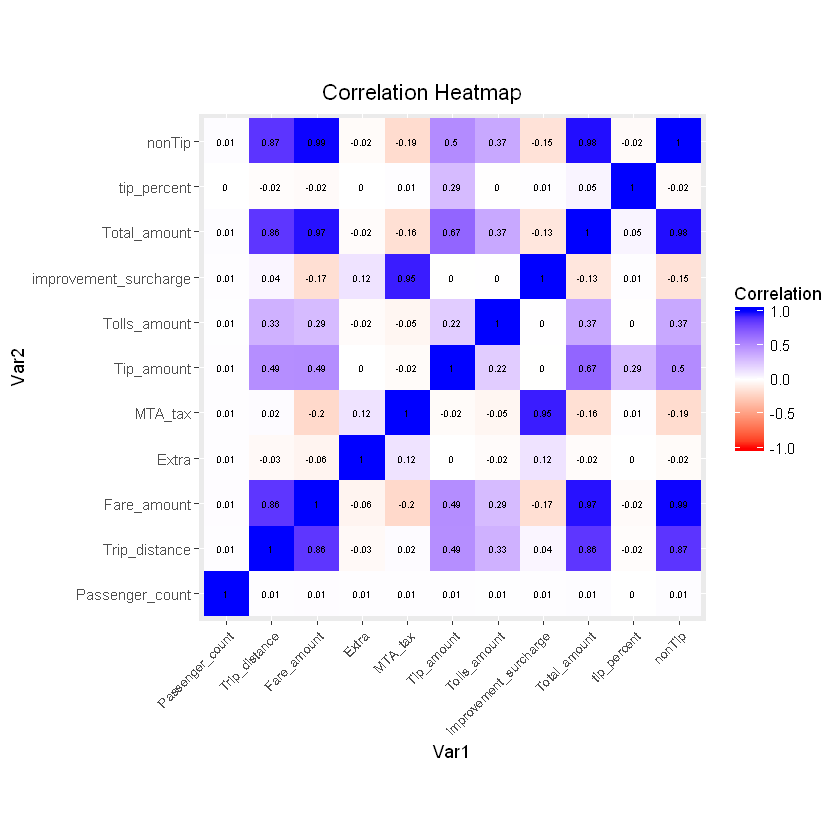

In [39]:
#CHART 6 -- CORRELATION PLOT
quantData = taxiDT[, list(Passenger_count, Trip_distance, Fare_amount, 
              Extra,MTA_tax, Tip_amount, Tolls_amount, 
              improvement_surcharge, Total_amount, tip_percent, nonTip)]

qplot(x=Var1, y=Var2, data=melt(cor(quantData, use='p')), fill=value, geom='tile') +
      scale_fill_gradient2(low='red', high='blue', mid = 'white', midpoint = 0, 
                           limit=c(-1,1), space='Lab', name='Correlation') + 
      theme(axis.text.x = element_text(angle=45, vjust=1, size=8, hjust = 1)) +
      coord_fixed() + ggtitle("Correlation Heatmap") + 
      theme(plot.title = element_text(hjust = 0.4)) +
      geom_text(aes(Var1, Var2, label=round(value,2)), color="black", size = 2)

Of course, we see high correlations between the extra fees and the total amount paid. When a toll is paid, it would make sense for the total amount to go up as well.

My initial hunch was that the longer one travels, the more exhausted and less generous they would feel at the end of the trip -- hence resulting in a lower tip percentage. Contrary to my initial hunch, it seems that the tip percent does not have a strong correlation with many of the continous variables, including as trip distance. 

## B) Focus on Tip Percent


### Figure 7: Weekday x Hour Tip Percent Heatmap

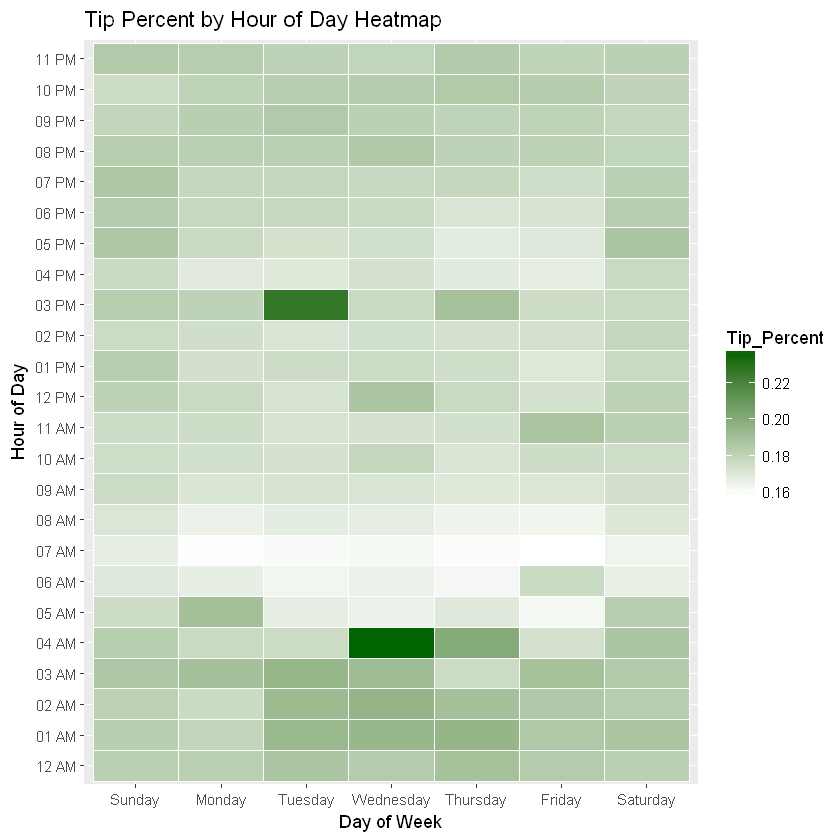

In [41]:
#CHART 7 -- Weekday x Hour tile chart
TP_time = taxiDT %>% group_by(weekday, PUhour) %>% 
          summarize(Tip_Percent = mean(tip_percent)) %>%
          mutate(Morning = substr(PUhour, 4, 5)) 

TP_time= TP_time[order(TP_time$Morning),]

ggplot(TP_time, aes(x=ordered(weekday, levels = c("Sunday", 
                                        "Monday", "Tuesday","Wednesday", "Thursday", 
                                        "Friday", "Saturday")), 
                                        y=ordered(PUhour, levels = c("12 AM", "01 AM", "02 AM",
                                        "03 AM", "04 AM", "05 AM", "06 AM", "07 AM", "08 AM", 
                                        "09 AM", "10 AM", "11 AM", "12 PM", "01 PM", "02 PM",
                                        "03 PM", "04 PM", "05 PM", "06 PM", "07 PM", 
                                        "08 PM", "09 PM", "10 PM", "11 PM")))) +
        geom_tile(aes(fill = Tip_Percent), color = "white") + 
        scale_fill_gradient(low = "white", high = 'darkgreen') + 
        xlab("Day of Week") + ylab("Hour of Day") + ggtitle("Tip Percent by Hour of Day Heatmap")

In Figure 7 above, we plot the average tip percentage for that hour and day of the week. Darker colors represent a higher tip percentage. We notice that people tend to tip higher percentages of their fares on Tuesdays and Wednesdays, between 3-4pm and 4-5am, respectively.

Typically, people don't tip well around 7am, no matter what day of the week it is!

# Part 4: Conclusion


During this analysis, I learned the following about Green Taxi rides in NYC:

 - People don't use these taxis that much more on the weekends. 
 
 - Over 80% of people take a taxi alone. Even when they ride with other people, they aren't swayed one way or another to change the amount they tip.
 
 - Riders tip largely according to the pre-coded tip percentages, despite the fact that some of those options are over 25%! This is much higher than the 15-18% gratuity that we are accustomed to giving in restaurants. 
 
 - As a taxi driver, people don't seem to be the most generous tippers between 6-8am. These are the hours when most people head to work. Perhaps an investigation into New Yorker job satisfaction is in order! But in all seriousness, people seem to tip slightly more in the evenings and just after midnight. 